## Import data and packages

In [566]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re

In [567]:
from fractions import Fraction 

In [568]:
df_all = pickle.load( open( "all_scraped_recipes.pickle", "rb" ) )

In [569]:
df_all.head()

,title,img_date,upload_date,features,calories,cook_time,recipe_steps,num_steps,author,ingredients,num_ingredients,tags,topnote,rating_count,avg_rating
0,Swordfish With Caramelized Eggplant and Capers,2020/10/07,NaN,"[Twice The Cooking, But Boundless Flavor]",NaN,45 minutes,[Set a broiler rack 4 inches from the heat sou...,7.0,Melissa Clark,"[pounds eggplant, cut into 1-inch cubes, table...",14,"[Seafood, Eggplant, Olives, Swordfish, Tomato,...","Soft, caramelized eggplant and chunks of meaty...",NaN,NaN
1,Salt-Baked New Potatoes With Pink-Peppercorn B...,2020/10/04,NaN,"[Buried In Salt, These Potatoes Are A Joy To Eat]",NaN,45 minutes,[Heat the oven to 400 degrees. Wash the potato...,8.0,Gabrielle Hamilton,"[pounds small, yellow-fleshed waxy potatoes (i...",7,"[American, Vegetables, Pink Peppercorn, Potato...",This way of cooking recently harvested new pot...,663,3
2,Jalapeño Jangjorim With Jammy Eggs,2020/09/30,NaN,[A Spread Worthy Of Royalty],NaN,"2 hours, plus cooling","[In a medium pot over high heat, bring 6 cups ...",6.0,Eric Kim,"[Ice, as needed, large eggs, pound beef briske...",12,"[Korean, Meat, Beef Brisket, Garlic, Ginger, J...",Jangjorim is a Korean dish of soy sauce-braise...,11,4
3,"Gamja Salad With Cucumber, Carrot and Red Onion",2020/09/30,NaN,[A Spread Worthy Of Royalty],NaN,40 minutes,"[In a small bowl, combine the cucumber, red on...",5.0,Eric Kim,"[Kirby cucumber, deseeded and cut into 1/4-inc...",10,"[Korean, Salads And Dressings, Vegetables, Car...",Gamja (“potato”) salad is likely to be include...,16,4
4,One-Pan Orzo With Spinach and Feta,2020/09/30,NaN,[This One Pan Pasta Still Feels Like Summer],NaN,30 minutes,"[Heat a 10-inch skillet over medium, then melt...",4.0,Melissa Clark,"[tablespoons unsalted butter, large scallions,...",11,"[Pastas, Feta, Lemon, Orzo, Spinach, Dinner, E...","Similar to spanakorizo, a Greek spinach and ri...",463,4


In [570]:
df_all.shape

(1920, 15)

## Clean data

### Check that all columns have the correct datatype; fix as needed

In [571]:
# convert columns to floats and strings as needed
df_all[['calories','rating_count','avg_rating']] = df_all[['calories','rating_count','avg_rating']].apply(pd.to_numeric) 

df_all[['title','cook_time','author','topnote']] = df_all[['title','cook_time','author','topnote']].astype(str)



In [572]:
# translate both date columns into datetime types
df_all['upload_date'] = pd.to_datetime(df_all['upload_date'])
df_all['img_date'] = pd.to_datetime(df_all['img_date'])

# find the max of the two date columns as new column "date"
# rationale is that we want the date to represent the most recent date the recipe was promoted 
# (some older recipes are re-released)
df_all['date'] = df_all[['img_date','upload_date']].max(axis=1)

### Normalize all recipe cook times to total minutes

In [573]:
def extract_minutes(s):
    '''
    A helper function to extract total minutes from a string containing any number of minutes mentions
    
    Parameters
    ----------
    string : A string of text.
    
    Returns
    -------
    A floating point number if the string contains minutes and None otherwise.
    '''    
    total_min = 0
    try:
        # find any occurrences of hours
        for i in re.findall('[0-9]* minute',s):        
            i = i.strip('minute').rstrip().lstrip()
            # convert to float and sum accross all occurrences
            i = float(i)
            total_min += i
        return total_min
    except AttributeError:
        return 0

In [574]:
def extract_hours(s):
    '''
    A helper function to extract total hour from a string containing 0-1 hour mentions
    
    Parameters
    ----------
    string : A string of text.
    
    Returns
    -------
    A floating point number if the string contains hour mention and None otherwise.
    '''     
    try:
        # find any occurrences of hours
        x = re.search('[0-9 ]+[ /0-9]+(hour)',s).group(0).strip('hour').rstrip()      
        # convert any instances of fractions and entire number to float
        return float(sum(Fraction(term) for term in x.split()))
    
    except AttributeError:
        return 0

In [575]:
# Using the minute and hour extraction formulas, create final time column called "total_time_min"

df_all['minutes'] = df_all['cook_time'].apply(extract_minutes)
df_all['hours'] = df_all['cook_time'].apply(extract_hours)
df_all['total_time_min'] = df_all['minutes'] + df_all['hours']*60

### Check for missing/erroneous data and drop as needed

In [576]:
# check which variables are missing data
df_all.isnull().sum()

title                 0
img_date              0
upload_date        1797
features            587
calories            696
cook_time             0
recipe_steps         36
num_steps            36
author                0
ingredients           0
num_ingredients       0
tags                  0
topnote               0
rating_count          5
avg_rating            5
date                  0
minutes               0
hours                 0
total_time_min        0
dtype: int64

We're missing some data in the following categories:
- **upload date:** expected and not an issue; this should only have a value if the recipe was updated and reposted, otherwise we'll use the "img_date" field for most recipes
- **features:** expected and not an issue; I know that not every recipe gets a feature. This will likely become a binary feature
- **calories:** expected and presents a problem. I knew that not *every* recipe has nutritional information yet, but it seems like only 36% of my scraped recipes have this information. If I want to use it, I'll have to limit my dataset or try to impute the missing values
- **recipe steps and num steps:** unexpected, but not a major issue since it's only two percent of my data. I'll just drop these rows entirely.
- **rating count and avg rating:** unexpected, but not a major issue since it's only 0.2 percent of my data. I'll just drop these rows entirely.

In [577]:
df_all.describe()

,calories,num_steps,num_ingredients,rating_count,avg_rating,minutes,hours,total_time_min
count,1224.000000,1884.000000,1920.000000,1915.000000,1915.000000,1920.000000,1920.000000,1920.000000
mean,449.046569,4.773885,12.282292,585.856397,4.348303,20.204167,0.869792,72.391667
std,267.673228,1.943120,4.799199,885.891243,0.488468,18.292881,1.610991,91.377768
min,5.000000,1.000000,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000
25%,245.750000,3.000000,9.000000,127.500000,4.000000,0.000000,0.000000,30.000000
50%,396.000000,4.000000,12.000000,299.000000,4.000000,20.000000,0.000000,45.000000
75%,595.250000,6.000000,15.000000,697.500000,5.000000,35.000000,1.000000,90.000000
max,1300.000000,18.000000,32.000000,14067.000000,5.000000,105.000000,24.000000,1465.000000


In [578]:
# drop all rows where identified columns are NaN
df = df_all.dropna(subset=['recipe_steps','num_steps','rating_count','avg_rating'])

In [579]:
# check recipes that came out to total_time_min=0 
df_all[df_all['total_time_min'] == 0].head(5).sort_values('cook_time')

,title,img_date,upload_date,features,calories,cook_time,recipe_steps,num_steps,author,ingredients,num_ingredients,tags,topnote,rating_count,avg_rating,date,minutes,hours,total_time_min
338,Weeknight Chicken Marbella,2020-10-04,NaT,NaN,NaN,45 minutes,[Heat olive oil in a large skillet over high u...,3.0,Rick A. Martinez,"[tablespoon extra-virgin olive oil, bone-in, s...",12,"[Poultry, Bay Leaves, Chicken, Garlic, Green O...",The chicken Marbella recipe from “The Silver P...,844.0,4.0,2020-10-04,0.0,0.0,0.0
12,Turkey Brine,2020-09-21,NaT,NaN,NaN,nan,[In a pot or cooler large enough to hold turke...,1.0,Sam Sifton,"[cups kosher salt, plus more as needed, cup gr...",7,"[American, Poultry, Bay Leaves, Herb Sprig, Pe...",This classic wet brine is adapted from an old ...,NaN,NaN,2020-09-21,0.0,0.0,0.0
378,Perfect Boiled Eggs,2019-09-25,NaT,[How To Boil The Perfect Egg],NaN,nan,[Find a lidded saucepan large enough to allow ...,3.0,J. Kenji López-Alt,[Up to 12 eggs (see note)],1,"[Egg, Breakfast, Brunch, Dinner, Easy, Quick, ...","If your goal is perfectly smooth, blemish-free...",1419.0,4.0,2019-09-25,0.0,0.0,0.0
604,Miso-Glazed Eggplant With a Bowl of Rice,2019-02-17,NaT,NaN,NaN,nan,NaN,NaN,Sam Sifton,[],0,"[Vegetables, Japanese Eggplant, Miso, Sesame O...","This is a no-recipe recipe, a recipe without a...",307.0,4.0,2019-02-17,0.0,0.0,0.0
605,Sloppy Joes,2019-02-17,NaT,NaN,NaN,nan,NaN,NaN,Sam Sifton,[],0,"[American, Sandwiches, Canned Tomato, Ground B...","This is a no-recipe recipe, a recipe without a...",745.0,4.0,2019-02-17,0.0,0.0,0.0


In [580]:
# drop all rows where total cook time is 0
mask = df['total_time_min'] == 0
df = df[~mask]
df.shape

(1852, 19)

## Exploratory Data Analysis

### Determine reasonable date range
We don't want to penalize more recent recipes that may not have had time yet to accumulate ratings, nor do we want to penalize old recipes released before Cooking usership grew.

In [581]:
# mean ratings count by quarter
quarterly = df.groupby(pd.Grouper(key='date', freq='Q')).agg({'rating_count':['count','mean', 'sem']}).round(0).reset_index()
quarterly

date rating_count               
                     count    mean    sem
0  2008-09-30            1   102.0    NaN
1  2008-12-31            0     NaN    NaN
2  2009-03-31            0     NaN    NaN
3  2009-06-30            4   107.0   26.0
4  2009-09-30            0     NaN    NaN
5  2009-12-31            0     NaN    NaN
6  2010-03-31            0     NaN    NaN
7  2010-06-30            1   156.0    NaN
8  2010-09-30            0     NaN    NaN
9  2010-12-31            0     NaN    NaN
10 2011-03-31            0     NaN    NaN
11 2011-06-30            0     NaN    NaN
12 2011-09-30            1   405.0    NaN
13 2011-12-31            1   327.0    NaN
14 2012-03-31            1   312.0    NaN
15 2012-06-30            0     NaN    NaN
16 2012-09-30            0     NaN    NaN
17 2012-12-31            0     NaN    NaN
18 2013-03-31            0     NaN    NaN
19 2013-06-30            0     NaN    NaN
20 2013-09-30            0     NaN    NaN
21 2013-12-31           14   179.0   54.0
22 2014-03-31          108   457.0   75.0
23 2014-06-30           76   295.0   48.0
24 2014-09-30           93   257.0   68.0
25 2014-12-31          120   334.0   41.0
26 2015-03-31           81   388.0   55.0
27 2015-06-30           55   602.0  135.0
28 2015-09-30           37   488.0   78.0
29 2015-12-31           23   468.0   99.0
30 2016-03-31           17   605.0  155.0
31 2016-06-30           15  1108.0  609.0
32 2016-09-30           18   578.0  136.0
33 2016-12-31           27   305.0   99.0
34 2017-03-31           54   666.0   97.0
35 2017-06-30           42   449.0   65.0
36 2017-09-30           44   767.0  226.0
37 2017-12-31           36   363.0   88.0
38 2018-03-31           42   644.0  170.0
39 2018-06-30           34   623.0  138.0
40 2018-09-30           95   607.0   90.0
41 2018-12-31          107   922.0  154.0
42 2019-03-31          121   753.0   67.0
43 2019-06-30           91   589.0   64.0
44 2019-09-30           84   611.0   84.0
45 2019-12-31          102   733.0   90.0
46 2020-03-31          100   783.0  112.0
47 2020-06-30           99   710.0   75.0
48 2020-09-30          104   798.0   99.0
49 2020-12-31            4  1802.0  980.0

In [582]:
# remove any observations prior to 3/31/16, when it looks like ratings counts may have trended lower
df = df[df['date'] >= '2016-03-31']

# remove any very recent obsercations; from mid-September 2020 or later
df = df[df['date'] <= '2020-09-15']
df.shape

(1192, 19)

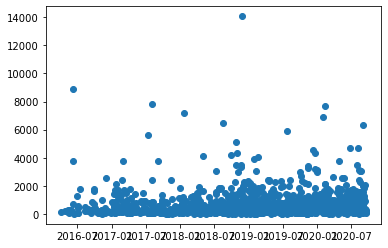

In [583]:
# sns.lmplot(x='date',y='rating_count',data=df, fit_reg=True)
plt.scatter(x=df['date'],y=df['rating_count'])

In [584]:
df['date'].max()

Timestamp('2020-09-15 00:00:00')

In [585]:
df[df['rating_count'] <= 20]

,title,img_date,upload_date,features,calories,cook_time,recipe_steps,num_steps,author,ingredients,num_ingredients,tags,topnote,rating_count,avg_rating,date,minutes,hours,total_time_min
47,"Toasted Millet Salad With Cucumber, Avocado an...",2020-08-11,NaT,NaN,NaN,"45 minutes, plus cooling","[To a small pot set over medium heat, add the ...",4.0,Yewande Komolafe,"[cup millet or other grains, such as barley, f...",10,"[Grains And Rice, Salads And Dressings, Almond...",Cooked millet has a taste and aroma that’s sub...,11.0,4.0,2020-08-11,45.0,0.00,45.0
136,Barszcz (Classic Polish Borscht),2020-04-22,NaT,"[In Poland, Communist Era Restaurants Are Perf...",NaN,3 hours,"[In a large pot, combine the beets, bones, car...",5.0,Anne Applebaum,"[medium beets (about 1 1/2 pounds), peeled — 3...",15,"[Eastern European, Soups And Stews, Beef Bone,...",Most Slavic countries have their own form of b...,17.0,3.0,2020-04-22,0.0,3.00,180.0
315,Roast Turkey With Berry-Mint Sauce and Black W...,2019-11-06,NaT,[Sean Sherman’s 10 Essential Native American R...,NaN,"About 2 hours, plus chilling and resting",[Remove giblets from the turkey cavity and dis...,7.0,Sean Sherman,"[(10- to 12-pound) turkey, preferably a herita...",12,"[Poultry, Roasts, Black Walnut, Cranberry, Lee...",The flavor of heritage turkey breeds is richer...,11.0,4.0,2019-11-06,0.0,2.00,120.0
316,Rocky Mountain Rainbow Trout With Trout Roe,2019-11-06,NaT,[Sean Sherman’s 10 Essential Native American R...,NaN,20 minutes,[Open the trout fillets and fan out like a boo...,4.0,Sean Sherman,"[whole, head-on rainbow trout (about 3/4 pound...",7,"[Seafood, Rainbow Trout, Sumac, Trout Roe, Wal...","Whole trout makes for a stunning presentation,...",16.0,4.0,2019-11-06,20.0,0.00,20.0
643,Goose Pho,2019-02-06,NaT,[A New Breed Of Hunters Focuses On The Cooking],NaN,"2 hours, plus at least 5 hours’ simmering",[Heat oven to 375 degrees. Using a heavy cleav...,8.0,Wade Truong,"[goose, duck or chicken feet (about 1/2 pound ...",19,"[American, Vietnamese, Soups And Stews, Cinnam...",Wade Truong is the head chef at Kybecca in Fre...,5.0,2.0,2019-02-06,0.0,2.00,120.0
646,Goose Barbacoa,2019-02-06,NaT,[A New Breed Of Hunters Focuses On The Cooking],1209.0,"45 minutes, plus 2 to 4 hours’ simmering","[Combine the onion, lime juice, vinegar, garli...",5.0,Wade Truong,"[large red onion, roughly chopped, cup fresh l...",16,"[Meat, Broth, Chipotles In Adobo, Duck, Duck F...",The beefy nature of goose legs makes them a go...,13.0,4.0,2019-02-06,45.0,4.00,285.0
706,Venison Chops With Shallots and Cumin,2018-12-19,NaT,[Finding Harmony In Ribera Del Duero],191.0,1 hour 40 minutes,[Using a heavy skillet large enough to accommo...,4.0,Florence Fabricant,"[ounces smoked bacon (4 thick strips), rack of...",11,"[Meat, Dry Red Wine, Rack Of Venison, Shallot,...",Wintry weather and holiday get-togethers requi...,9.0,3.0,2018-12-19,40.0,1.00,100.0
732,Centerpiece Salmon With Thai Basil and Browned...,2018-11-21,NaT,[A Far Cry From Overcooked Turkey],550.0,1 3/4 hours,[Melt butter in a small saucepan over medium-h...,13.0,Yotam Ottolenghi,"[tablespoons/90 grams unsalted butter, cup/10 ...",13,"[Seafood, Radish, Salmon Fillet, Sunchoke, Tha...",This side of salmon is a festive centerpiece d...,14.0,4.0,2018-11-21,0.0,1.75,105.0
823,Smoked Bulgur and Pomegranate Salad,2018-09-12,NaT,[The Bestia And Bavel Chefs On Feasting After ...,NaN,1 1/2 hours,"[Prepare the bulgur: In a large, dry heavy pan...",5.0,Ori Menashe,"[large yellow Spanish onion, peeled and quarte...",23,"[Middle Eastern, Grains And Rice, Salads And D...",This colorful and flavorful mountain of bulgur...,14.0,4.0,2018-09-12,0.0,1.50,90.0
986,Rutabaga-Potato Mash With Bacon,2017-11-15,NaT,[‘I Became A Thanksgiving Orphan’],276.0,1 hour,"[In a large, heavy pot over medium heat, cook ...",3.0,Jessica B. Harris,"[strips bacon, pounds rutabagas, peeled and cu...",5,"[American, Bacon, Potato, Rutabaga, Dinner, Si...","For the food historian Jessica B. Harris, humb..

### log transforming target variable and pairplot of all numerical data 

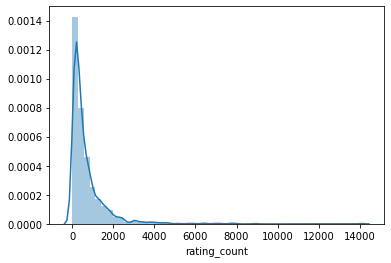

In [586]:
sns.distplot(df['rating_count']);

In [587]:
df['log_rating_count'] = np.log(df['rating_count'])

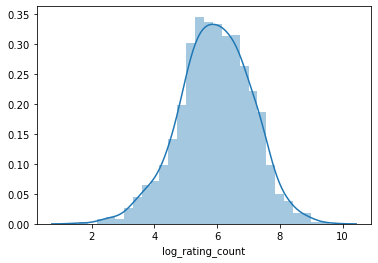

In [588]:
sns.distplot(df['log_rating_count']);

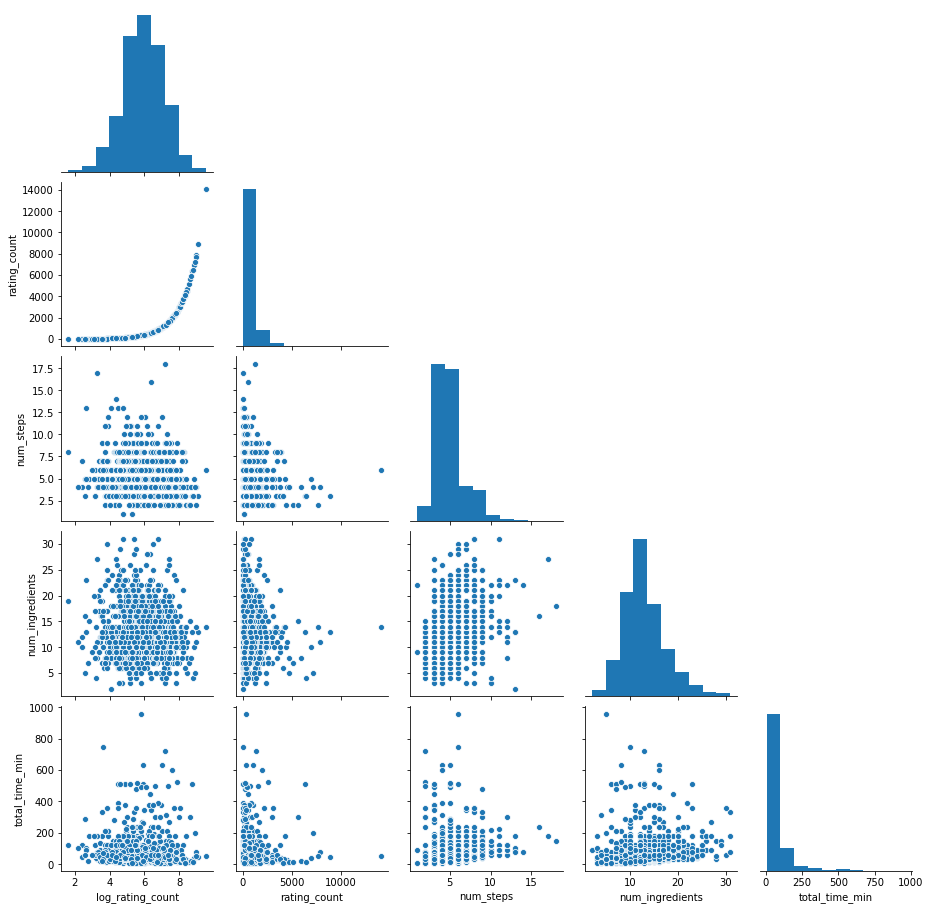

In [589]:
sns.pairplot(data=df[['log_rating_count','rating_count','num_steps','num_ingredients','total_time_min']], corner=True);

### Recipe 'Features'

In [590]:
# create variable indicating whether recipe got a feature or not
df['featured'] = df['features'].isna().apply(lambda x: 1 if x==0 else 0)
df[['featured','features']].head(10)

,featured,features
20,0,NaN
22,1,[I Think Of My Grandfather Every Time I Make K...
23,0,NaN
24,0,NaN
25,0,NaN
26,1,[Tracing A Classic Jewish Dish Throughout The ...
27,1,"[The Elements Of Wok Hei, And How To Capture T..."
28,1,[Savor Summer Longer With This Cherry Tomato P...
29,0,NaN
30,1,[3 Highly Portable Picnic Options That Aren’t ...


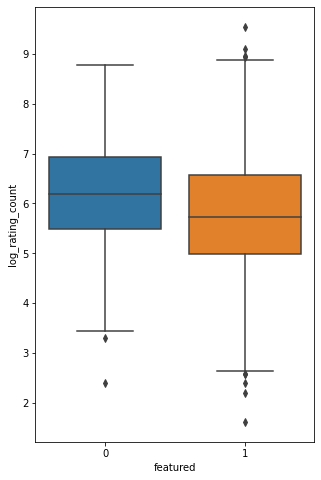

In [591]:
# relationship between this and target variable is not strong; don't think I'll include in model
fig, ax = plt.subplots(figsize=(5,8))
sns.boxplot(y=df['log_rating_count'],x=df['featured']);

### Exploration of author impact and creating dummy variables

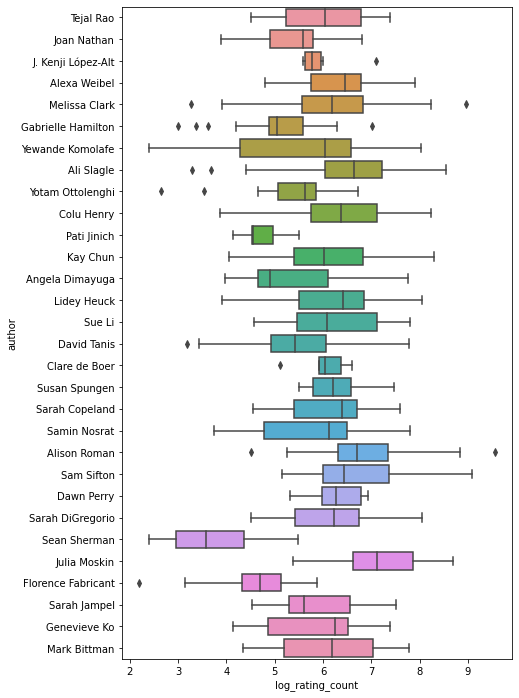

In [592]:
fig, ax = plt.subplots(figsize=(7,12))
sns.boxplot(y=df_top_auth['author'],x=df_top_auth['log_rating_count'],orient="h");

In [593]:
# create dataframe of top 30 contributing authors only (i.e. those with ~7 or more recipes)
topauth = df['author'].value_counts().index[:30].tolist()
df_top_auth = df[df['author'].isin(topauth)]

# explore differences in popularity by author
author_summary = df_top_auth.groupby(by=['author']).agg({'rating_count': ['count','mean', 'sem', 'median']}).reset_index(
).sort_values(('rating_count', 'count'), ascending=False).round(0)
author_summary

author rating_count                       
                              count    mean    sem  median
17       Melissa Clark          161   756.0   66.0   488.0
6          David Tanis          124   339.0   34.0   225.0
1           Ali Slagle           75  1198.0  141.0   766.0
2         Alison Roman           59  1398.0  260.0   816.0
5           Colu Henry           58   852.0  103.0   586.0
14            Kay Chun           47   738.0  117.0   409.0
22    Sarah DiGregorio           46   701.0  106.0   508.0
15         Lidey Heuck           35   707.0  105.0   605.0
0         Alexa Weibel           31   707.0   95.0   642.0
21      Sarah Copeland           30   642.0   96.0   597.0
29    Yotam Ottolenghi           25   295.0   39.0   278.0
20        Samin Nosrat           21   524.0  119.0   455.0
28    Yewande Komolafe           20   548.0  157.0   418.0
19          Sam Sifton           20  1640.0  510.0   628.0
9   Gabrielle Hamilton           19   231.0   57.0   157.0
25              Sue Li           17   738.0  161.0   439.0
26       Susan Spungen           14   604.0  111.0   494.0
27           Tejal Rao           14   566.0  120.0   422.0
13        Julia Moskin           13  1946.0  480.0  1239.0
8   Florence Fabricant           12   134.0   29.0   111.0
10        Genevieve Ko           10   515.0  149.0   514.0
3      Angela Dimayuga           10   435.0  220.0   136.0
7           Dawn Perry            8   611.0  109.0   530.0
16        Mark Bittman            8   824.0  301.0   510.0
23        Sarah Jampel            8   564.0  214.0   270.0
24        Sean Sherman            7    73.0   33.0    36.0
11  J. Kenji López-Alt            7   444.0  127.0   319.0
12         Joan Nathan            6   324.0  126.0   270.0
4        Clare de Boer            5   454.0   96.0   417.0
18         Pati Jinich            5   128.0   32.0    94.0

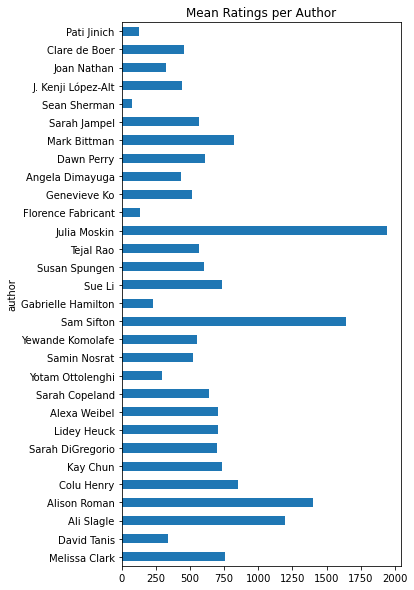

In [594]:
# chart the mean and standard error
author_summary.columns = ['author','count','mean','std_error','median']
ax = author_summary.plot(x='author',y='mean',
                  kind='barh',title='Mean Ratings per Author',legend=None,figsize=(5,10))

In [595]:
# the top 15 authors account for 64% of the data; we'll call the rest "other"
author_counts = df['author'].value_counts(normalize=True).cumsum()
author_counts

Melissa Clark            0.135067
David Tanis              0.239094
Ali Slagle               0.302013
Alison Roman             0.351510
Colu Henry               0.400168
                           ...   
Chandra Ram              0.996644
5-8 Club & Matt's Bar    0.997483
Tom Cunanan              0.998322
Kate Kavanaugh           0.999161
Josef Centeno            1.000000
Name: author, Length: 249, dtype: float64

In [596]:
# create list of other authors
other_authors = list(author_counts[author_counts > 0.64].index)

# create new author column with "other authors" replaced with "other"
df['auth'] = df['author'].copy()
df['auth'] = df['auth'].replace(other_authors,'Other') 

# create dummy variables for author
df = pd.get_dummies(df, columns=['auth'])
df.head()

,title,img_date,upload_date,features,calories,cook_time,recipe_steps,num_steps,author,ingredients,...,auth_Kay Chun,auth_Lidey Heuck,auth_Melissa Clark,auth_Other,auth_Sam Sifton,auth_Samin Nosrat,auth_Sarah Copeland,auth_Sarah DiGregorio,auth_Yewande Komolafe,auth_Yotam Ottolenghi
20,Khoresh Karafs (Persian Celery Stew With Lamb),2020-09-15,NaT,NaN,NaN,1 hour,[Trim or break off thicker parts of the parsle...,6.0,Daniela Galarza,"[large bunch curly parsley, small bunch fresh ...",...,0,0,0,1,0,0,0,0,0,0
22,Vegetarian Kofta Curry,2020-09-13,NaT,[I Think Of My Grandfather Every Time I Make K...,NaN,1 hour,"[Put the garlic, ginger and green chiles in a ...",5.0,Tejal Rao,"[garlic cloves, (2-inch) piece fresh ginger, p...",...,0,0,0,1,0,0,0,0,0,0
23,Amu’s Chicken Korma,2020-09-11,NaT,NaN,NaN,1 1/2 hours,"[Cut onion in half, trim off the root, and thi...",6.0,Sohla El-Waylly,"[large onion, peeled, plus more for serving, (...",...,0,0,0,1,0,0,0,0,0,0
24,Sheet-Pan Shrimp Boil,2020-09-15,NaT,NaN,NaN,50 minutes,[Heat oven to 425 degrees. Place a rack in the...,7.0,Millie Peartree,"[pound baby red or yellow potatoes, halved (or...",...,0,0,0,1,0,0,0,0,0,0
25,Crab and Shrimp Boil Pasta,2020-09-15,NaT,NaN,NaN,35 minutes,[Bring a large pot of salted water to boil for...,6.0,Millie Peartree,"[Kosher salt, pound smoked sausage, such as ki...",...,0,0,0,1,0,0,0,0,0,0


### Exploration of recipe tags

1. get an idea of how many distinct tags there are (10 is nbd, 50 is prob too much)
2. can combine based on domain knowledge if you want
3. group the rare ones into "other"

In [597]:
# top tags
top_tags = df['tags'].explode().value_counts()[:50].index.tolist()

df['tags'].explode().value_counts()[:50]

Dinner                  1192
Main Course             1048
Lunch                    458
Weekday                  378
Vegetables               263
Vegetarian               244
American                 240
Fall                     222
Side Dish                222
Easy                     206
Winter                   187
Weeknight                187
Quick                    184
Summer                   171
Poultry                  166
Soups And Stews          148
Appetizer                143
Seafood                  141
Pastas                   138
Spring                   112
Meat                     108
Garlic                   107
Tomato                   104
Brunch                   104
Ginger                   102
Italian                   99
Chicken                   98
Salads And Dressings      89
Vegan                     88
Scallion                  83
Lemon                     80
Parmesan                  78
Grains And Rice           74
Potato                    71
Cilantro      

In [536]:
# create new df with columns for top 50 tags
df_tags = df[['log_rating_count','tags']]
for i in top_tags:
    df_tags[i] = df_tags['tags'].apply(lambda x : 1 if i in x else 0)
    
# explore relationship for each of the top tags
#for t in top_tags:
#    plt.figure()
#    sns.boxplot(y=df_tags['log_rating_count'],x=df[t])

<ipython-input-536-c34b7af702e4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tags[i] = df_tags['tags'].apply(lambda x : 1 if i in x else 0)


In [599]:
df.shape

(1192, 36)

In [600]:
# create lists of similar tags with association
easy = ['Weekday', 'Weeknight', 'Easy', 'Quick', 'One Pot']
side = ['Appetizer','Snack','Salads And Dressings','Side Dish']
ginger = ['Ginger']
italian = ['Italian','Pastas','Pasta']
chicken = ['Chicken','Poultry','Chicken Thigh']
veg = ['Vegan','Vegetarian']

# create list of tag group lists
tag_groups = [easy,side,ginger,italian,chicken,veg]
print(tag_groups)    

[['Weekday', 'Weeknight', 'Easy', 'Quick', 'One Pot'], ['Appetizer', 'Snack', 'Salads And Dressings', 'Side Dish'], ['Ginger'], ['Italian', 'Pastas', 'Pasta'], ['Chicken', 'Poultry', 'Chicken Thigh'], ['Vegan', 'Vegetarian']]


In [631]:
# create new columns in dataframe indicating 1 or 0 for whether recipe is tagged in each group
for t in tag_groups:
    pattern = '|'.join(t)
    col_title = t[0]
    pattern_results = []
    for index,row in df.iterrows():
        actual_tags_str = ",".join(row['tags'])
        if any(i in actual_tags_str for i in t): 
            pattern_results.append(1)
        else:
            pattern_results.append(0)
    df[col_title] = pattern_results
df.head()

,title,img_date,upload_date,features,calories,cook_time,recipe_steps,num_steps,author,ingredients,...,auth_Sarah Copeland,auth_Sarah DiGregorio,auth_Yewande Komolafe,auth_Yotam Ottolenghi,Weekday,Appetizer,Ginger,Italian,Chicken,Vegan
20,Khoresh Karafs (Persian Celery Stew With Lamb),2020-09-15,NaT,NaN,NaN,1 hour,[Trim or break off thicker parts of the parsle...,6.0,Daniela Galarza,"[large bunch curly parsley, small bunch fresh ...",...,0,0,0,0,0,0,0,0,0,0
22,Vegetarian Kofta Curry,2020-09-13,NaT,[I Think Of My Grandfather Every Time I Make K...,NaN,1 hour,"[Put the garlic, ginger and green chiles in a ...",5.0,Tejal Rao,"[garlic cloves, (2-inch) piece fresh ginger, p...",...,0,0,0,0,0,0,1,0,0,1
23,Amu’s Chicken Korma,2020-09-11,NaT,NaN,NaN,1 1/2 hours,"[Cut onion in half, trim off the root, and thi...",6.0,Sohla El-Waylly,"[large onion, peeled, plus more for serving, (...",...,0,0,0,0,0,0,1,0,1,0
24,Sheet-Pan Shrimp Boil,2020-09-15,NaT,NaN,NaN,50 minutes,[Heat oven to 425 degrees. Place a rack in the...,7.0,Millie Peartree,"[pound baby red or yellow potatoes, halved (or...",...,0,0,0,0,0,0,0,0,0,0
25,Crab and Shrimp Boil Pasta,2020-09-15,NaT,NaN,NaN,35 minutes,[Bring a large pot of salted water to boil for...,6.0,Millie Peartree,"[Kosher salt, pound smoked sausage, such as ki...",...,0,0,0,0,0,0,0,1,0,0


## Building a Model

In [633]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

In [634]:
df.columns

Index(['title', 'img_date', 'upload_date', 'features', 'calories', 'cook_time',
       'recipe_steps', 'num_steps', 'author', 'ingredients', 'num_ingredients',
       'tags', 'topnote', 'rating_count', 'avg_rating', 'date', 'minutes',
       'hours', 'total_time_min', 'log_rating_count', 'featured',
       'auth_Alexa Weibel', 'auth_Ali Slagle', 'auth_Alison Roman',
       'auth_Colu Henry', 'auth_David Tanis', 'auth_Kay Chun',
       'auth_Lidey Heuck', 'auth_Melissa Clark', 'auth_Other',
       'auth_Sam Sifton', 'auth_Samin Nosrat', 'auth_Sarah Copeland',
       'auth_Sarah DiGregorio', 'auth_Yewande Komolafe',
       'auth_Yotam Ottolenghi', 'Weekday', 'Appetizer', 'Ginger', 'Italian',
       'Chicken', 'Vegan'],
      dtype='object')

In [635]:
# define features and target
# leaving out 'auth_Other'
X = df[['total_time_min','num_ingredients','num_steps','auth_Alexa Weibel',
       'auth_Ali Slagle', 'auth_Alison Roman', 'auth_Colu Henry',
       'auth_David Tanis', 'auth_Kay Chun', 'auth_Lidey Heuck',
       'auth_Melissa Clark', 'auth_Sam Sifton',
       'auth_Samin Nosrat', 'auth_Sarah Copeland', 'auth_Sarah DiGregorio',
       'auth_Yewande Komolafe', 'auth_Yotam Ottolenghi','Weekday', 'Appetizer', 'Ginger', 'Italian',
       'Chicken', 'Vegan']]
y = df['log_rating_count']


In [636]:
model = LinearRegression()
fit = model.fit(X,y)
fit.score(X,y)

0.23642457357717628

In [637]:
def cv_results(X, y, model=LinearRegression(normalize=True), scoring='r2', rounding=4, cv=5, minimize_score=False):
    '''
    For a set of features and target X, y, perform a 5 fold cross validation.
    Fit and validate a model, and report results
    Note: `sklearn.model_selection.cross_validate` defaults to 5 fold, 80/20 validation splits.
    '''
    
    model_cv = cross_validate(model, X, y, cv=cv, return_train_score=True, 
                              scoring=scoring, return_estimator=True)

    if minimize_score:
        select = model_cv['test_score'].argmin()
    else:
        select = model_cv['test_score'].argmax()

    final_model = model_cv['estimator'][select]
    
    # Capture the ratio between the train and test scores to understand possible under/over fitting
    model_cv['train_test_score_ratio'] = model_cv['train_score'] / model_cv['test_score']
    
    mean_score = round(model_cv['test_score'].mean(), rounding)
    min_score = round(model_cv['test_score'].min(), rounding)
    max_score = round(model_cv['test_score'].max(), rounding)
    
    mean_ratio = round(model_cv['train_test_score_ratio'].mean(), rounding)
    min_ratio = round(model_cv['train_test_score_ratio'].min(), rounding)
    max_ratio = round(model_cv['train_test_score_ratio'].max(), rounding)
    
    # report results
    print(f'Test {scoring} {":":<15} Mean = {mean_score}\tRange = ({min_score}, {max_score})')
    print(f'Train/Test {scoring} Ratio {":":<3} Mean = {mean_ratio}\tRange = ({min_ratio}, {max_ratio})')
    
    print('\nBest Model Feature coefficient results:')
    for feature, coef in zip(X.columns, final_model.coef_):
        print(f'{feature + ":":<16} {coef:.2f}')

In [638]:
cv_results(X,y)

Test r2 :               Mean = 0.1665	Range = (0.0195, 0.2618)
Train/Test r2 Ratio :   Mean = 3.829	Range = (0.8593, 14.2362)

Best Model Feature coefficient results:
total_time_min:  0.00
num_ingredients: -0.00
num_steps:       -0.04
auth_Alexa Weibel: 0.48
auth_Ali Slagle: 0.62
auth_Alison Roman: 1.14
auth_Colu Henry: 0.38
auth_David Tanis: -0.16
auth_Kay Chun:   0.17
auth_Lidey Heuck: 0.54
auth_Melissa Clark: 0.62
auth_Sam Sifton: 0.98
auth_Samin Nosrat: 0.47
auth_Sarah Copeland: 0.15
auth_Sarah DiGregorio: 0.25
auth_Yewande Komolafe: 0.03
auth_Yotam Ottolenghi: 0.02
Weekday:         0.40
Appetizer:       -0.22
Ginger:          0.35
Italian:         0.14
Chicken:         0.51
Vegan:           0.33


**baseline model with only numeric data**

- features = df[['total_time_min','num_ingredients','num_steps']]
- target = df['rating_count']
- r^2 = 0.02


In [ ]:

# look into grouping train/test by date
# log transform the target variable or inverse